# Grad CAM
https://arxiv.org/abs/1610.02391

![alt text](static/gradcam.jpg "Logo Title Text 1")


tensor([242])
Pooled gradients shape torch.Size([2048])


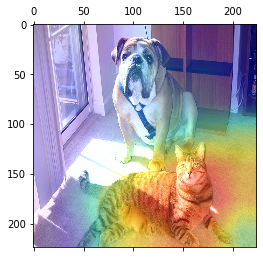

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2


# ResNet Class
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet152
        self.resnet = resnet152(pretrained=True)
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x

      
# all the data transformation and loading
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = ImageFolder(root='/home/i008/dsr-pytorch/images', transform=transform)
dataloader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

# init the resnet
resnet = ResNet()
resnet.eval()

# set the evaluation mode
# _ = resnet.eval()

# get the image
img, _ = next(iter(dataloader))

# forward pass
pred = resnet(img)

print(pred.argmax(dim=1))  # prints tensor([2])

# print(resnet.gradient)

# get the gradient of the output with respect to the parameters of the model
# pred[:, 242].backward(retain_graph=True)
pred[:, 282].backward(retain_graph=True)


# pull the gradients out of the model
gradients = resnet.get_gradient()

# print(gradients)


# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print("Pooled gradients shape", pooled_gradients.shape)

# pooled_gradients = torch.zeros_like(pooled_gradients)

# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()

# weight the channels by corresponding gradients
# for i in range(2048):
#     activations[:, i, :, :] *= pooled_gradients[i] 
    
activations = activations * pooled_gradients[None, :, None, None]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

# make the heatmap to be a numpy array
heatmap = heatmap.numpy()

# interpolate the heatmap
img = cv2.imread('./images/shark/cat_dog.png')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
plt.imshow(plt.imread('./map.jpg'))
